<a href="https://colab.research.google.com/github/karhol/mock-portfolio/blob/main/Breast_Cancer_Wisconsin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast Cancer Wisconsin

Dataset: 
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/code?datasetId=180&sortBy=voteCount


Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy
from scipy import stats
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [50]:
data = pd.read_csv('data.csv')
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [3]:
data["Unnamed: 32"].isnull().sum()

569

"Unnamed: 32" looks like it is in the mistake in the dataset. we will drop it in the preprocessing

# EDA

Take a look at the target

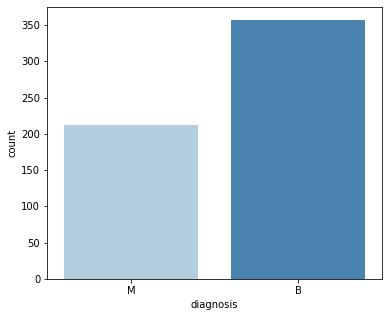

In [55]:
plt.figure(figsize = (6,5))
sns.countplot(x="diagnosis", data=data, palette='Blues')

will need to change the target from an object to a binary integer {0 : 1}

# Correlation Matrix: Heatmap

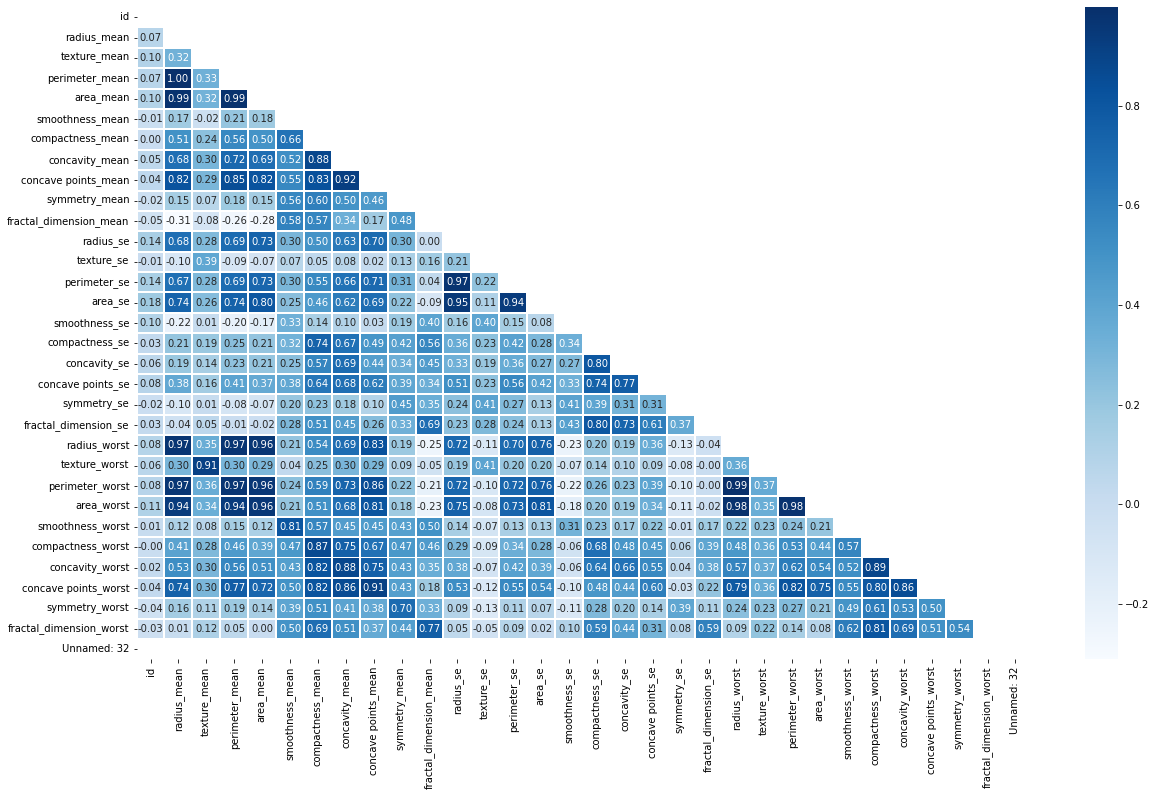

In [5]:
plt.figure(figsize = (20, 12))

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(corr, mask = mask, linewidths = 1, annot = True, fmt = ".2f", cmap="Blues") 
plt.show()

# Remove Highly Correlated Variables

In [6]:
# removing highly correlated features
data1 = data.copy()

corr_matrix = data.corr().abs() 

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
tri_df = corr_matrix.mask(mask)

to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.92)]

data = data.drop(to_drop, axis = 1)

print(f"The old dataframe had {data1.shape[1]} columns.")
print(f"The new dataframe has {data.shape[1]} columns.")


The old dataframe had 33 columns.
The new dataframe has 25 columns.


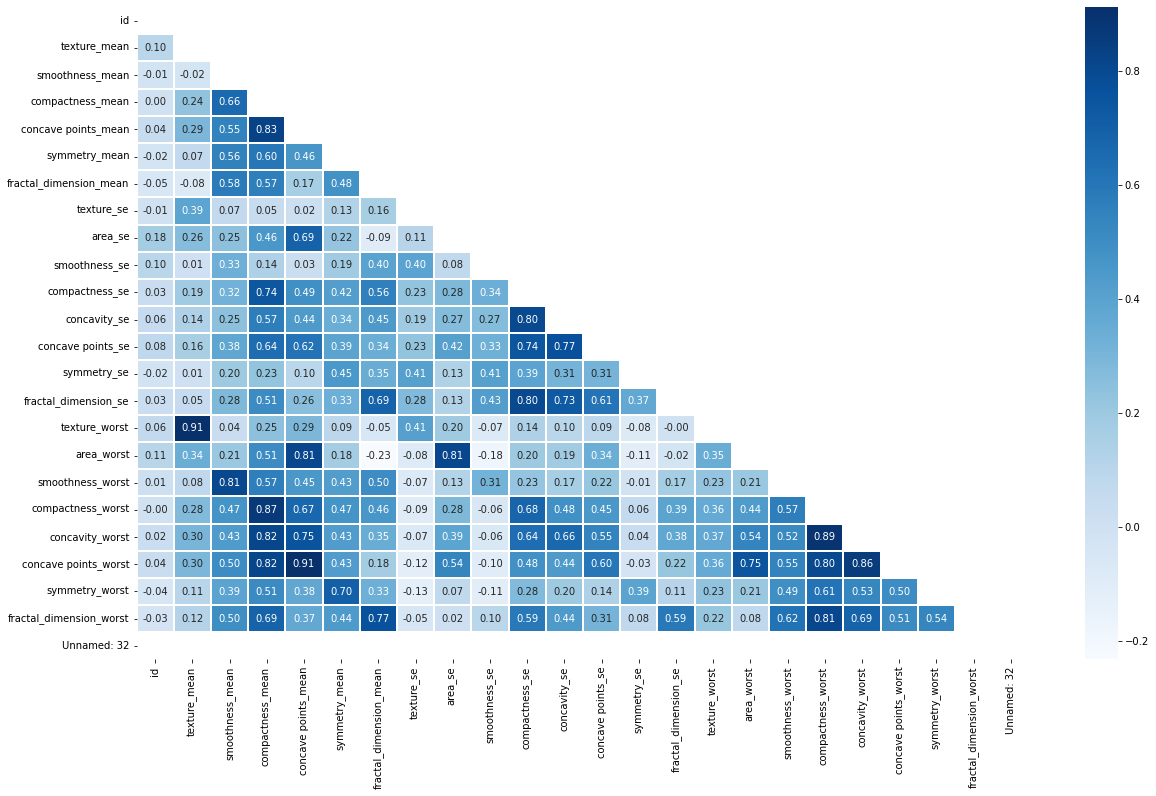

In [7]:
plt.figure(figsize = (20, 12))

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(corr, mask = mask, linewidths = 1, annot = True, fmt = ".2f", cmap="Blues")
plt.show()

# Outlier Detection

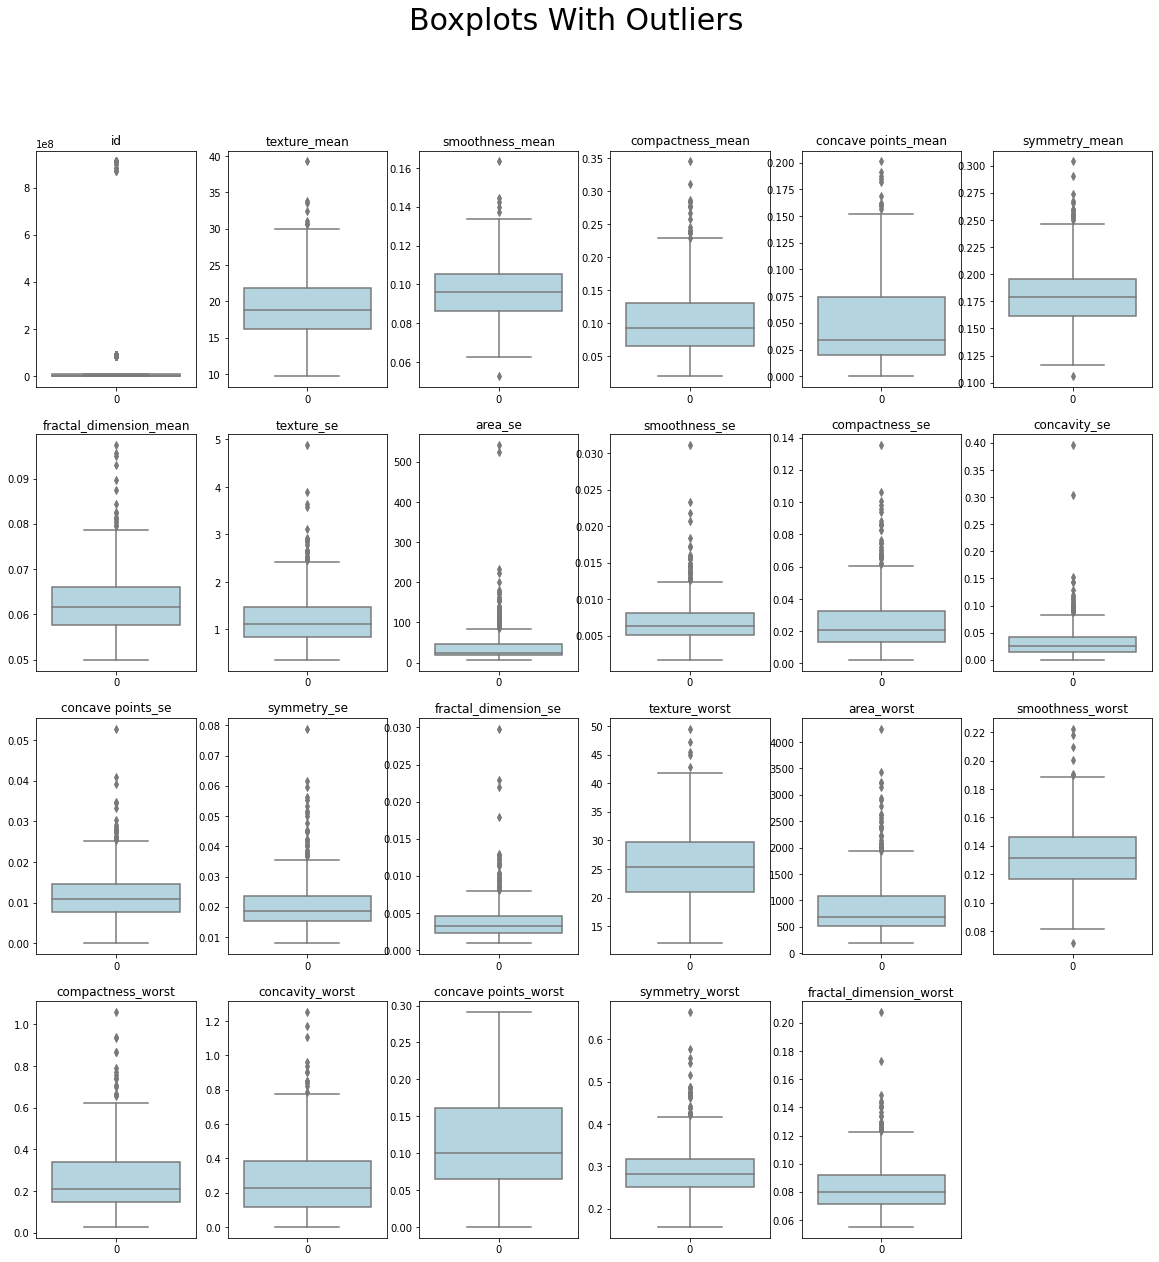

In [8]:
eda_df = data.drop('diagnosis', axis=1).copy()

nonbinary_columns = [column for column in eda_df.columns if len(eda_df[column].unique()) > 2]

plt.figure(figsize=(20, 20))

for i, column in enumerate(nonbinary_columns):
    plt.subplot(4, 6, i + 1)
    sns.boxplot(data=eda_df[column], color='lightblue')
    plt.title(column)

plt.suptitle("Boxplots With Outliers", size=30)
plt.show()

we have lots of outliers, we will need to work on dropping the extreme outliers, so the data is less affected by them 

# Outlier Removal Function

In [9]:
# I got this function from Gabriel Atkins
# easy to compare a model with and without outliers

def remove_outliers(df, columns, threshold):
    df = df.copy()
    
    # Calculate the lower and upper bounds on the Z distribution given a threshold value
    lower_bound = scipy.stats.norm.ppf(q=(threshold / 2), loc=0, scale=1)
    upper_bound = scipy.stats.norm.ppf(q=1 - (threshold / 2), loc=0, scale=1)
    
    # Calculate z-scores of every example in the columns specified
    outlier_df = df.loc[:, columns].copy()
    zscores = pd.DataFrame(scipy.stats.zscore(outlier_df, axis=0), index=outlier_df.index, columns=outlier_df.columns)
    
    # Get boolean arrays denoting the outlier examples
    lower_outliers = (zscores < lower_bound).any(axis=1)
    upper_outliers = (zscores >= upper_bound).any(axis=1)
    
    # Get indicies of all outlier examples
    outliers = df[pd.concat([lower_outliers, upper_outliers], axis=1).any(axis=1)].index
    
    # Drop the outliers
    df = df.drop(outliers, axis=0).reset_index(drop=True)
    print(len(outliers), "examples dropped.")
    
    return df

193 examples dropped.


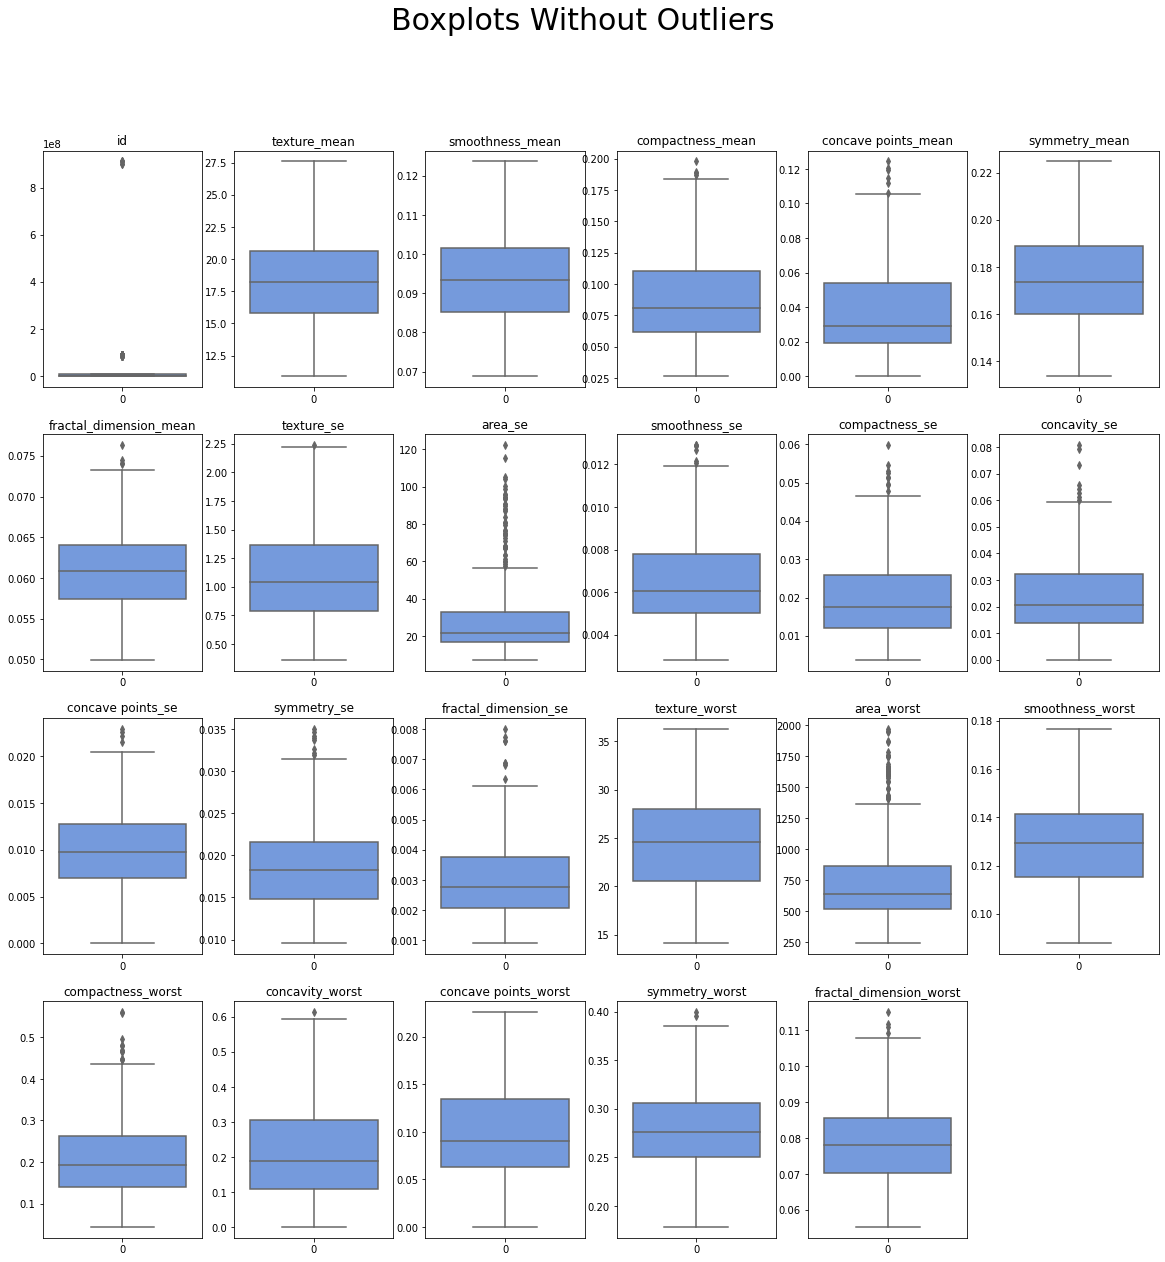

In [10]:
outliers_df = remove_outliers(
      data,
      columns=[
          'texture_mean',
          'smoothness_mean',
          'compactness_mean',
          'concave points_mean',
          'symmetry_mean',
          'fractal_dimension_mean',
          'texture_se',
          'area_se',
          'smoothness_se',
          'compactness_se',
          'concavity_se',
          'concave points_se',
          'symmetry_se',
          'fractal_dimension_se',
          'texture_worst',
          'area_worst',
          'smoothness_worst',
          'compactness_worst',
          'concavity_worst',
          'concave points_worst',
          'symmetry_worst',
          'fractal_dimension_worst'
        ],
        threshold=0.05
)

plt.figure(figsize=(20, 20))

for i, column in enumerate(nonbinary_columns):
    plt.subplot(4, 6, i + 1)
    sns.boxplot(data=outliers_df[column], color='cornflowerblue')
    plt.title(column)

plt.suptitle("Boxplots Without Outliers", size=30)
plt.show()

It can seem like there are still many outliers, however this isnt about eliminating all the outliers. It is just about eliminating the more extreme outliers that dont help the model.

# Preprocessing

In [11]:
def preprocessing(df, keep_outliers=True, outlier_threshold=0.05):
  
  # Drop useless variables (Unnamed: 32 , id)
  df = df.drop(['Unnamed: 32','id'],axis = 1)

  # make target Binary
  df.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

  # Train-test Split
  train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)
  
  # Remove outliers
  if keep_outliers == False:
      train_df = remove_outliers(
          train_df,
          columns=[ 
              'texture_mean',
              'smoothness_mean',
              'compactness_mean',
              'concave points_mean',
              'symmetry_mean',
              'fractal_dimension_mean',
              'texture_se',
              'area_se',
              'smoothness_se',
              'compactness_se',
              'concavity_se',
              'concave points_se',
              'symmetry_se',
              'fractal_dimension_se',
              'texture_worst',
              'area_worst',
              'smoothness_worst',
              'compactness_worst',
              'concavity_worst',
              'concave points_worst',
              'symmetry_worst',
              'fractal_dimension_worst'
          ],
          threshold=outlier_threshold
      )
  
  # Split df into X and y
  y_train = train_df['diagnosis']
  y_test = test_df['diagnosis']
  X_train = train_df.drop('diagnosis', axis=1)
  X_test = test_df.drop('diagnosis', axis=1)
  
  # Scaling X
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

  return X_train, X_test, y_train, y_test

It is very important to not remove outliers in the test set, as this data is with which prove our models worth.
If we also eliminate the outliers in the test set, we will get a model that looks great but is actually overfitting and we will have no way to know what is going on.

# Simple model with and without outliers

In [12]:
X_train1, X_test1, y_train1, y_test1 = preprocessing(data, keep_outliers=True)

model1 = LogisticRegression()
model1.fit(X_train1, y_train1)
print("Accuracy: {:.3f}%".format(accuracy_score(y_train1, model1.predict(X_train1))*100))
print("Test Accuracy: {:.3f}%".format(model1.score(X_test1, y_test1) * 100))

Accuracy: 98.995%
Test Accuracy: 95.906%


In [13]:
X_train2, X_test2, y_train2, y_test2 = preprocessing(data, keep_outliers=False, outlier_threshold=0.005)

model2 = LogisticRegression()
model2.fit(X_train2, y_train2)
print("Accuracy: {:.3f}%".format(accuracy_score(y_train2, model2.predict(X_train2))*100))
print("Test Accuracy: {:.3f}%".format(model2.score(X_test2, y_test2) * 100))

62 examples dropped.
Accuracy: 98.810%
Test Accuracy: 97.076%


The model preforms best when i remove .5% of the outliers

# Looking for the Best Models

In [48]:
models = []
models.append(['Logistic Regression', LogisticRegression(random_state=0)])
models.append(['SVM', SVC(random_state=0)])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier(random_state=0)])
models.append(['Random Forest', RandomForestClassifier(random_state=0)])
models.append(['XGBoost', XGBClassifier(eval_metric= 'error')])

lst_1= []

for m in range(len(models)):
    lst_2= []
    model = models[m][1]
    model.fit(X_train2, y_train2)
    y_pred = model.predict(X_test2)
    cm = confusion_matrix(y_test2, y_pred)  #Confusion Matrix
    accuracies = cross_val_score(estimator = model, X = X_train2, y = y_train2, cv = 10)   #K-Fold Validation
    roc = roc_auc_score(y_test2, y_pred)  #ROC AUC Score
    precision = precision_score(y_test2, y_pred)  #Precision Score
    recall = recall_score(y_test2, y_pred)  #Recall Score
    f1 = f1_score(y_test2, y_pred)  #F1 Score

    lst_2.append(models[m][0])
    lst_2.append((accuracy_score(y_test2, y_pred))*100) 
    lst_2.append(accuracies.mean()*100)
    lst_2.append(accuracies.std()*100)
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

In [49]:
df = pd.DataFrame(lst_1, columns= ['Model', 'Accuracy', 'K-Fold Mean Accuracy', 'Std. Deviation', 'ROC AUC', 'Precision', 'Recall', 'F1'])

df.sort_values(by= ['Accuracy', 'K-Fold Mean Accuracy'], inplace= True, ascending= False)

df



,Model,Accuracy,K-Fold Mean Accuracy,Std. Deviation,ROC AUC,Precision,Recall,F1
0,Logistic Regression,97.076023,97.923351,2.304245,0.966931,0.967742,0.952381,0.960000
6,Random Forest,95.906433,95.846702,2.985726,0.947751,0.982759,0.904762,0.942149
2,KNeighbors,94.736842,95.552585,2.712275,0.931878,0.982143,0.873016,0.924370
7,XGBoost,93.567251,95.534759,2.383348,0.922619,0.948276,0.873016,0.909091
1,SVM,92.982456,96.737968,2.772166,0.904762,1.000000,0.809524,0.894737
3,GaussianNB,92.982456,92.272727,5.147944,0.931217,0.880597,0.936508,0.907692
5,Decision Tree,90.643275,91.105169,4.890409,0.889550,0.912281,0.825397,0.866667
4,BernoulliNB,90.058480,90.187166,7.599569,0.904762,0.828571,0.920635,0.872180


# Tuning the Models

In [24]:
from sklearn.model_selection import GridSearchCV

grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0]}]), 
               (KNeighborsClassifier(),[{'n_neighbors':[5,7,8,10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]), 
               (SVC(),[{'C':[0.25,0.5,0.75,1],'kernel':['linear', 'rbf'],'random_state':[0]}]), 
               (GaussianNB(),[{'var_smoothing': [1e-09]}]), 
               (BernoulliNB(), [{'alpha': [0.25, 0.5, 1]}]), 
               (DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'random_state':[0]}]), 
               (RandomForestClassifier(),[{'n_estimators':[100,150,200],'criterion':['gini','entropy'],'random_state':[0]}]), 
              (XGBClassifier(), [{'learning_rate': [0.01, 0.05, 0.1], 'eval_metric': ['error']}])]

In [26]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv = 10)
    grid.fit(X_train2, y_train2)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

LogisticRegression():
Best Accuracy : 97.92%
Best Parameters :  {'C': 1, 'random_state': 0}

----------------

KNeighborsClassifier():
Best Accuracy : 95.86%
Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 10}

----------------

SVC():
Best Accuracy : 98.22%
Best Parameters :  {'C': 0.5, 'kernel': 'linear', 'random_state': 0}

----------------

GaussianNB():
Best Accuracy : 92.27%
Best Parameters :  {'var_smoothing': 1e-09}

----------------

BernoulliNB():
Best Accuracy : 90.78%
Best Parameters :  {'alpha': 0.25}

----------------

DecisionTreeClassifier():
Best Accuracy : 93.18%
Best Parameters :  {'criterion': 'entropy', 'random_state': 0}

----------------

RandomForestClassifier():
Best Accuracy : 96.74%
Best Parameters :  {'criterion': 'entropy', 'n_estimators': 100, 'random_state': 0}

----------------

XGBClassifier():
Best Accuracy : 95.53%
Best Parameters :  {'eval_metric': 'error', 'learning_rate': 0.05}

----------------



# Top Three Choices

Logistic Regression

Accuracy: 98.810%

Test Accuracy: 97.076%

K-Fold Validation Mean Accuracy: 97.92 %

Standard Deviation: 2.30 %

ROC AUC Score: 0.97

Precision: 0.97

Recall: 0.95

F1: 0.96
-----------------------------------



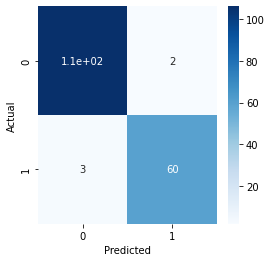

In [54]:
log_model = LogisticRegression(C=1 , random_state=0)

log_model.fit(X_train2, y_train2)
print("Accuracy: {:.3f}%".format(accuracy_score(y_train2, log_model.predict(X_train2))*100))
print("")
print("Test Accuracy: {:.3f}%".format(log_model.score(X_test2, y_test2) * 100))

y_pred = log_model.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = log_model, X = X_train2, y = y_train2, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test2, y_pred)  #ROC AUC Score
precision = precision_score(y_test2, y_pred)  #Precision Score
recall = recall_score(y_test2, y_pred)  #Recall Score
f1 = f1_score(y_test2, y_pred)  #F1 Score

plt.figure(figsize=(4,4))
sns.heatmap(cm,annot=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")

print("")
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')

Support Vector Classification

Accuracy: 98.810%

Test Accuracy: 93.567%

K-Fold Validation Mean Accuracy: 98.22 %

Standard Deviation: 1.96 %

ROC AUC Score: 0.93

Precision: 0.91

Recall: 0.92

F1: 0.91
-----------------------------------



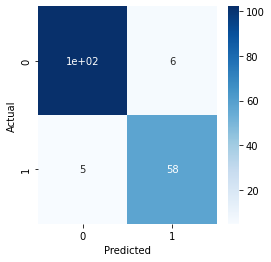

In [53]:
svc_model = SVC(C= 0.5, kernel="linear" , random_state=0)

svc_model.fit(X_train2, y_train2)
print("Accuracy: {:.3f}%".format(accuracy_score(y_train2, svc_model.predict(X_train2))*100))
print('')
print("Test Accuracy: {:.3f}%".format(svc_model.score(X_test2, y_test2) * 100))

y_pred = svc_model.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = svc_model, X = X_train2, y = y_train2, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test2, y_pred)  #ROC AUC Score
precision = precision_score(y_test2, y_pred)  #Precision Score
recall = recall_score(y_test2, y_pred)  #Recall Score
f1 = f1_score(y_test2, y_pred)  #F1 Score

plt.figure(figsize=(4,4))
sns.heatmap(cm,annot=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")

print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')


Random Forest Classifier

Accuracy: 100.000%

Test Accuracy: 96.491%

K-Fold Validation Mean Accuracy: 96.74 %

Standard Deviation: 2.77 %

ROC AUC Score: 0.96

Precision: 0.98

Recall: 0.92

F1: 0.95
-----------------------------------



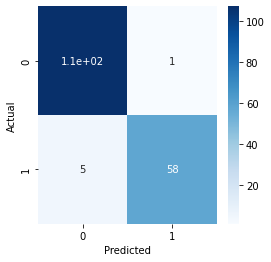

In [52]:
rfc_model = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=0)

rfc_model.fit(X_train2, y_train2)
print("Accuracy: {:.3f}%".format(accuracy_score(y_train2, rfc_model.predict(X_train2))*100))
print('')
print("Test Accuracy: {:.3f}%".format(rfc_model.score(X_test2, y_test2) * 100))
y_pred = rfc_model.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = rfc_model, X = X_train2, y = y_train2, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test2, y_pred)  #ROC AUC Score
precision = precision_score(y_test2, y_pred)  #Precision Score
recall = recall_score(y_test2, y_pred)  #Recall Score
f1 = f1_score(y_test2, y_pred)  #F1 Score


plt.figure(figsize=(4,4))
sns.heatmap(cm,annot=True,cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")


print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')


Logistic Regression is the best model we could build.

# Save the Logistic Regression trained model

In [ ]:
import pickle
filename = 'trained_model.sav'
pickle.dump(log_model, open(filename, 'wb'))


References:

https://www.kaggle.com/code/mirichoi0218/classification-breast-cancer-or-not-with-15-ml

https://www.kaggle.com/code/gcdatkin/outliers-satisfaction-prediction?scriptVersionId=54254235

https://www.kaggle.com/code/siddheshera/stroke-eda-smote-9-models-90-accuracy

https://www.kaggle.com/code/hoturam/breast-cancer-diagnostic-prediction

https://www.kaggle.com/code/casper6290/strokeprediction-99-acc
